In [1]:
from pathlib import Path
import sys

# More reliable: get the project root from the notebook's location
ROOT_PATH = Path(__file__).parent.parent if '__file__' in globals() else Path.cwd().parent
# Or even better for notebooks:
ROOT_PATH = Path().resolve().parent  # Goes up from notebooks/ folder

sys.path.append(str(ROOT_PATH))

In [2]:
import scipy

mat_sample = scipy.io.loadmat(r'C:\Users\nguye\Documents\GitHub\orion-ae-study\data\raw\original\measurementSeries_B\05cNm\salves_out_05cNm_B_Fs5MHz_Tf1s_2019-04-02-16-22-00_1.mat')

In [3]:
vibrometer_signal = mat_sample['D'].squeeze()

In [69]:
import numpy as np

def find_zero_crossings(signal, direction='both'):
    """
    Find zero-crossing indices in a signal.
    
    Args:
        signal: 1D array of signal values
        direction: 'positive' (negative to positive), 'negative' (positive to negative), 
                   or 'both' (all crossings)
    
    Returns:
        Array of indices where zero-crossings occur
    """
    # Check for positive-going crossings: negative before, positive after
    positive_crossings = np.where((signal[:-1] < 0) & (signal[1:] > 0))[0]
    
    # Check for negative-going crossings: positive before, negative after
    negative_crossings = np.where((signal[:-1] > 0) & (signal[1:] < 0))[0]
    
    if direction == 'positive':
        return positive_crossings
    elif direction == 'negative':
        return negative_crossings
    else:  # 'both'
        # Combine and sort
        all_crossings = np.concatenate([positive_crossings, negative_crossings])
        return np.sort(all_crossings)

In [41]:
# Find all zero-crossings
zero_crossings = find_zero_crossings(vibrometer_signal, direction='both')
print(f"Found {len(zero_crossings)} zero-crossings")

# Optionally, find only positive-going crossings (negative to positive)
positive_crossings = find_zero_crossings(vibrometer_signal, direction='positive')
print(f"Found {len(positive_crossings)} positive-going crossings")

Found 997 zero-crossings
Found 499 positive-going crossings


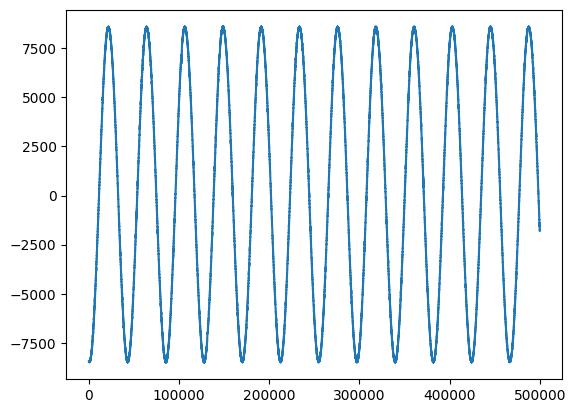

In [52]:
from matplotlib import pyplot as plt

plt.plot(vibrometer_signal[0:500000])

In [53]:
from scipy import signal as scipy_signal

def smooth_signal(signal, method='lowpass', **kwargs):
    """
    Smooth/filter signal to remove small spikes and extract main pattern.
    
    Args:
        signal: 1D array of signal values
        method: 'lowpass', 'savgol', 'median', or 'moving_avg'
        **kwargs: Method-specific parameters
    
    Returns:
        Smoothed signal
    """
    if method == 'lowpass':
        # Low-pass Butterworth filter
        fs = kwargs.get('fs', 5e6)  # Sampling frequency
        cutoff = kwargs.get('cutoff', 10000)  # Cutoff frequency in Hz (adjust based on your signal)
        order = kwargs.get('order', 4)  # Filter order
        
        nyquist = fs / 2
        normal_cutoff = cutoff / nyquist
        b, a = scipy_signal.butter(order, normal_cutoff, btype='low', analog=False)
        filtered_signal = scipy_signal.filtfilt(b, a, signal)
        return filtered_signal
    
    elif method == 'savgol':
        # Savitzky-Golay filter (preserves peaks well)
        window_length = kwargs.get('window_length', 501)  # Must be odd
        polyorder = kwargs.get('polyorder', 3)  # Polynomial order
        
        if window_length % 2 == 0:
            window_length += 1  # Ensure odd
        if window_length > len(signal):
            window_length = len(signal) if len(signal) % 2 == 1 else len(signal) - 1
            
        filtered_signal = scipy_signal.savgol_filter(signal, window_length, polyorder)
        return filtered_signal
    
    elif method == 'median':
        # Median filter (good for removing spikes)
        kernel_size = kwargs.get('kernel_size', 51)  # Must be odd
        
        if kernel_size % 2 == 0:
            kernel_size += 1
        filtered_signal = scipy_signal.medfilt(signal, kernel_size=kernel_size)
        return filtered_signal
    
    elif method == 'moving_avg':
        # Moving average
        window_size = kwargs.get('window_size', 100)
        filtered_signal = np.convolve(signal, np.ones(window_size)/window_size, mode='same')
        return filtered_signal
    
    else:
        raise ValueError(f"Unknown method: {method}")

In [ ]:
# Option 1: Low-pass filter (recommended for periodic signals)
# Adjust cutoff based on your vibration frequency
# If vibration is ~100 Hz, use cutoff around 500-1000 Hz to remove spikes but keep main pattern
# fs = 5e6  # Your sampling frequency
# cutoff = 1000  # Adjust this - higher = less smoothing, lower = more smoothing
# smoothed_signal = smooth_signal(vibrometer_signal, method='lowpass', fs=fs, cutoff=cutoff, order=4)

# # Option 2: Savitzky-Golay (preserves peak shapes)
# smoothed_signal = smooth_signal(vibrometer_signal, method='savgol', window_length=501, polyorder=3)

# # Option 3: Median filter (good for spike removal)
# smoothed_signal = smooth_signal(vibrometer_signal, method='median', kernel_size=51)

# Option 4: Moving average (simplest)
# smoothed_signal = smooth_signal(vibrometer_signal, method='moving_avg', window_size=100)

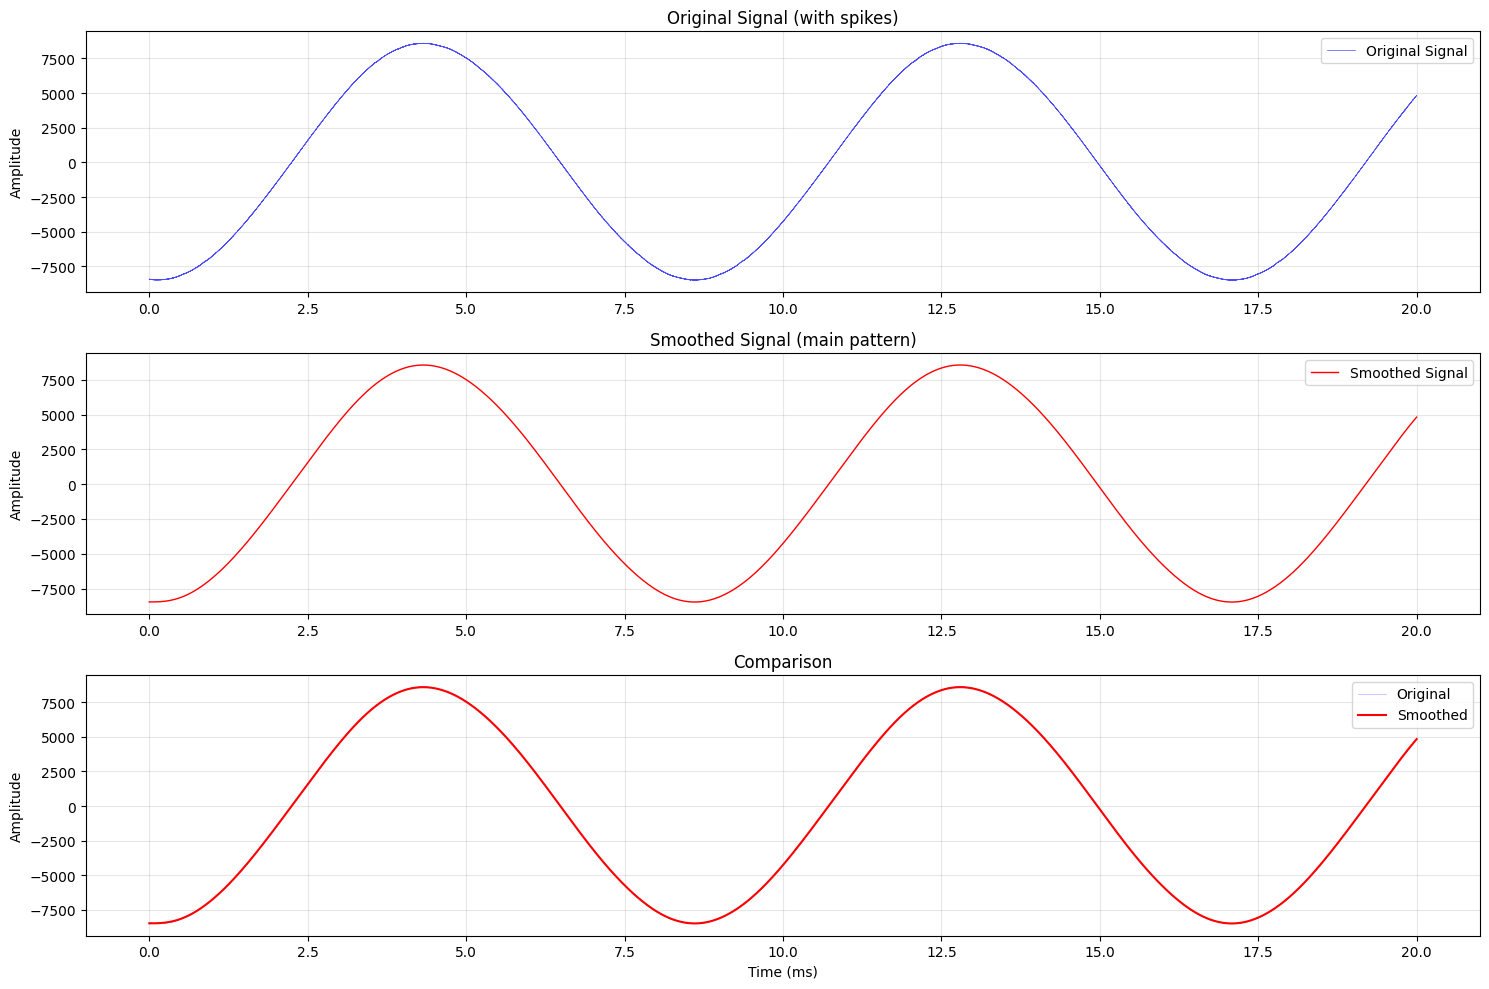

In [66]:
import matplotlib.pyplot as plt

# Apply smoothing
fs = 5e6
smoothed_signal = smooth_signal(vibrometer_signal, method='lowpass', fs=fs, cutoff=1000, order=4)

# Plot comparison
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# Original signal
time = np.arange(len(vibrometer_signal)) / fs * 1000  # in ms
zoom_start = 0
zoom_end = min(100000, len(vibrometer_signal))

axes[0].plot(time[zoom_start:zoom_end], vibrometer_signal[zoom_start:zoom_end], 
             'b-', linewidth=0.5, alpha=0.7, label='Original Signal')
axes[0].set_title('Original Signal (with spikes)')
axes[0].set_ylabel('Amplitude')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Smoothed signal
axes[1].plot(time[zoom_start:zoom_end], smoothed_signal[zoom_start:zoom_end], 
             'r-', linewidth=1, label='Smoothed Signal')
axes[1].set_title('Smoothed Signal (main pattern)')
axes[1].set_ylabel('Amplitude')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Overlay comparison
axes[2].plot(time[zoom_start:zoom_end], vibrometer_signal[zoom_start:zoom_end], 
             'b-', linewidth=0.5, alpha=0.3, label='Original')
axes[2].plot(time[zoom_start:zoom_end], smoothed_signal[zoom_start:zoom_end], 
             'r-', linewidth=1.5, label='Smoothed')
axes[2].set_title('Comparison')
axes[2].set_xlabel('Time (ms)')
axes[2].set_ylabel('Amplitude')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [70]:
# Find all zero-crossings
smoothed_zero_crossings = find_zero_crossings(smoothed_signal, direction='both')
print(f"Found {len(zero_crossings)} zero-crossings")

# Optionally, find only positive-going crossings (negative to positive)
smoothed_positive_crossings = find_zero_crossings(smoothed_signal, direction='positive')
print(f"Found {len(positive_crossings)} positive-going crossings")

Found 997 zero-crossings
Found 499 positive-going crossings


In [71]:
smoothed_zero_crossings

array([  11230,   32431,   53603,   74805,   95977,  117179,  138348,
        159555,  180719,  201929,  223093,  244298,  265465,  286667,
        307839,  329039,  350211,  371414,  392586,  413789,  434957,
        456161,  477328,  498537,  519701,  540904,  562075,  583275,
        604447,  625646,  646818,  668023,  689193,  710399,  731565,
        752772,  773934,  795144,  816308,  837511,  858682,  879880,
        901054,  922255,  943428,  964631,  985800, 1007006, 1028170,
       1049381, 1070542, 1091748, 1112916, 1134119, 1155289, 1176491,
       1197661, 1218866, 1240037, 1261241, 1282407, 1303614, 1324780,
       1345987, 1367154, 1388354, 1409525, 1430726, 1451897, 1473101,
       1494270, 1515476, 1536642, 1557850, 1579013, 1600224, 1621388,
       1642591, 1663759, 1684961, 1706134, 1727335, 1748504, 1769709,
       1790879, 1812086, 1833251, 1854458, 1875623, 1896830, 1917996,
       1939199, 1960369, 1981571, 2002739, 2023943, 2045113, 2066318,
       2087487, 2108

In [74]:
vibrometer_signal[smoothed_positive_crossings[0]:smoothed_positive_crossings[1]]

array([ -5.7985168 ,  -5.7985168 ,  -5.7985168 , ..., -16.47999512,
        -5.7985168 ,  -5.7985168 ], shape=(42373,))

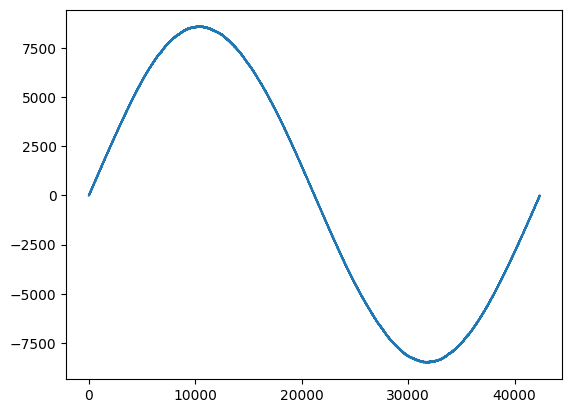

In [75]:
plt.plot(vibrometer_signal[smoothed_positive_crossings[0]:smoothed_positive_crossings[1]])

In [94]:
def detect_vibration_cycles(zero_crossings, min_cycle_length=None, max_cycle_length=None):
    """
    Detect vibration cycles from zero-crossings.
    
    Each cycle is typically defined as the interval between two consecutive 
    positive-going (or negative-going) zero-crossings.
    
    Args:
        zero_crossings: Array of zero-crossing indices
        min_cycle_length: Minimum samples per cycle (optional filter)
        max_cycle_length: Maximum samples per cycle (optional filter)
    
    Returns:
        List of tuples: (cycle_start_idx, cycle_end_idx, cycle_length_samples)
    """
    if len(zero_crossings) < 2:
        return []
    
    cycles = []
    for i in range(len(zero_crossings) - 1):
        start_idx = zero_crossings[i]
        end_idx = zero_crossings[i + 1]
        cycle_length = end_idx - start_idx
        
        # Optional filtering
        if min_cycle_length and cycle_length < min_cycle_length:
            continue
        if max_cycle_length and cycle_length > max_cycle_length:
            continue
        
        cycles.append((start_idx, end_idx, cycle_length))
    
    return cycles


def detect_vibration_cycles_with_peaks(signal, start_with_positive=True, min_cycle_length=None, max_cycle_length=None):
    """
    Detect vibration cycles with peak identification.
    
    Args:
        signal: 1D array of signal values
        start_with_positive: 
            - True: Cycle is 0 (neg→pos) → pos peak → 0 (pos→neg) → neg peak → 0 (neg→pos)
            - False: Cycle is 0 (pos→neg) → neg peak → 0 (neg→pos) → pos peak → 0 (pos→neg)
        min_cycle_length: Minimum samples per cycle (optional filter)
        max_cycle_length: Maximum samples per cycle (optional filter)
    
    Returns:
        List of tuples: (start_idx, first_peak_idx, mid_zero_idx, second_peak_idx, end_idx, cycle_length)
        - If start_with_positive=True: (start, pos_peak, mid_zero, neg_peak, end, length)
        - If start_with_positive=False: (start, neg_peak, mid_zero, pos_peak, end, length)
    """
    # Find positive-going (neg→pos) and negative-going (pos→neg) zero-crossings
    positive_crossings = find_zero_crossings(signal, direction='positive')
    negative_crossings = find_zero_crossings(signal, direction='negative')
    
    if len(positive_crossings) == 0 or len(negative_crossings) == 0:
        return []
    
    cycles = []
    
    if start_with_positive:
        # Pattern: 0 (neg→pos) → pos peak → 0 (pos→neg) → neg peak → 0 (neg→pos)
        starting_crossings = positive_crossings
        mid_crossings = negative_crossings
        ending_crossings = positive_crossings
    else:
        # Pattern: 0 (pos→neg) → neg peak → 0 (neg→pos) → pos peak → 0 (pos→neg)
        starting_crossings = negative_crossings
        mid_crossings = positive_crossings
        ending_crossings = negative_crossings
    
    for i, start_idx in enumerate(starting_crossings):
        # Find the next mid zero-crossing after start
        next_mid = mid_crossings[mid_crossings > start_idx]
        if len(next_mid) == 0:
            continue
        mid_zero_idx = next_mid[0]
        
        # Find the next ending zero-crossing after mid
        next_end = ending_crossings[ending_crossings > mid_zero_idx]
        if len(next_end) == 0:
            continue
        end_idx = next_end[0]
        
        cycle_length = end_idx - start_idx
        
        # Optional filtering
        if min_cycle_length and cycle_length < min_cycle_length:
            continue
        if max_cycle_length and cycle_length > max_cycle_length:
            continue
        
        # Find peaks within cycle segments
        if start_with_positive:
            # First segment: start to mid_zero (should contain positive peak)
            first_segment = signal[start_idx:mid_zero_idx]
            first_peak_local = np.argmax(first_segment)  # Positive peak
            first_peak_idx = start_idx + first_peak_local
            
            # Second segment: mid_zero to end (should contain negative peak)
            second_segment = signal[mid_zero_idx:end_idx]
            second_peak_local = np.argmin(second_segment)  # Negative peak
            second_peak_idx = mid_zero_idx + second_peak_local
        else:
            # First segment: start to mid_zero (should contain negative peak)
            first_segment = signal[start_idx:mid_zero_idx]
            first_peak_local = np.argmin(first_segment)  # Negative peak
            first_peak_idx = start_idx + first_peak_local
            
            # Second segment: mid_zero to end (should contain positive peak)
            second_segment = signal[mid_zero_idx:end_idx]
            second_peak_local = np.argmax(second_segment)  # Positive peak
            second_peak_idx = mid_zero_idx + second_peak_local
        
        cycles.append((start_idx, first_peak_idx, mid_zero_idx, second_peak_idx, end_idx, cycle_length))
    
    return cycles

In [85]:
# Detect cycles (using positive-going crossings as cycle markers)
fs = 5e6
if len(smoothed_positive_crossings) >= 2:
    cycles = detect_vibration_cycles(smoothed_positive_crossings)
    print(f"Detected {len(cycles)} vibration cycles")
    
    if len(cycles) > 0:
        cycle_lengths = [c[2] for c in cycles]
        cycle_durations_ms = [c[2] * 1000 / fs for c in cycles]
        
        print(f"\nCycle statistics:")
        print(f"  Mean cycle length: {np.mean(cycle_lengths):.0f} samples ({np.mean(cycle_durations_ms):.4f} ms)")
        print(f"  Std cycle length: {np.std(cycle_lengths):.0f} samples ({np.std(cycle_durations_ms):.4f} ms)")
        print(f"  Min cycle length: {np.min(cycle_lengths)} samples ({np.min(cycle_durations_ms):.4f} ms)")
        print(f"  Max cycle length: {np.max(cycle_lengths)} samples ({np.max(cycle_durations_ms):.4f} ms)")

Detected 106 vibration cycles

Cycle statistics:
  Mean cycle length: 42373 samples (8.4745 ms)
  Std cycle length: 1 samples (0.0003 ms)
  Min cycle length: 42369 samples (8.4738 ms)
  Max cycle length: 42376 samples (8.4752 ms)


In [87]:
np.min(cycle_lengths)

np.int64(42369)

In [101]:
42369 / 5e6

0.0084738

In [92]:
import matplotlib.pyplot as plt

C:\Users\nguye\AppData\Local\Temp\ipykernel_57392\3034948516.py:48: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\nguye\Documents\GitHub\orion-ae-study\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


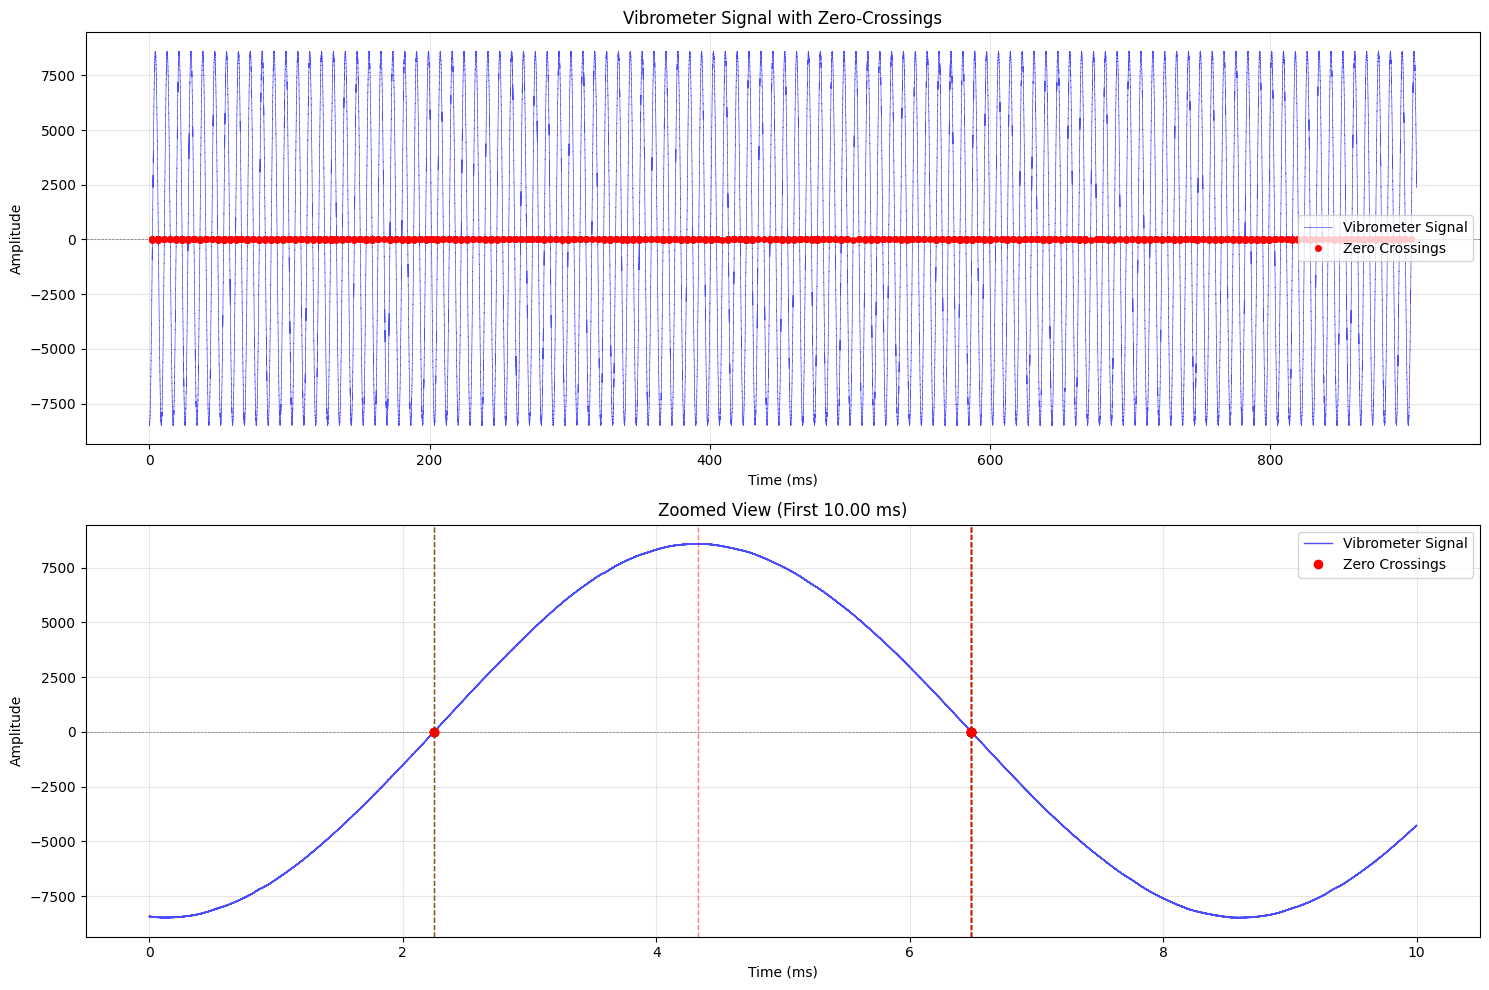

In [93]:
dt = 1.0 / fs  # Time step in seconds
time = np.arange(len(vibrometer_signal)) * dt  # Time array in seconds

# Visualize the signal with zero-crossings and cycle boundaries
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Full signal with zero-crossings
axes[0].plot(time * 1000, vibrometer_signal, 'b-', linewidth=0.5, alpha=0.7, label='Vibrometer Signal')
axes[0].axhline(y=0, color='k', linestyle='--', linewidth=0.5, alpha=0.5)
axes[0].plot(time[zero_crossings] * 1000, vibrometer_signal[zero_crossings], 
             'ro', markersize=4, label='Zero Crossings')
axes[0].set_xlabel('Time (ms)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Vibrometer Signal with Zero-Crossings')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Zoomed view showing cycles
zoom_start = 0
zoom_end = min(50000, len(vibrometer_signal))  # Show first 50000 samples
axes[1].plot(time[zoom_start:zoom_end] * 1000, vibrometer_signal[zoom_start:zoom_end], 
             'b-', linewidth=1, alpha=0.7, label='Vibrometer Signal')
axes[1].axhline(y=0, color='k', linestyle='--', linewidth=0.5, alpha=0.5)

# Mark zero-crossings in zoomed region
zoom_crossings = zero_crossings[(zero_crossings >= zoom_start) & (zero_crossings < zoom_end)]
axes[1].plot(time[zoom_crossings] * 1000, vibrometer_signal[zoom_crossings], 
             'ro', markersize=6, label='Zero Crossings')

# Mark cycle boundaries if detected
if len(cycles) > 0:
    cycle_starts = [c[0] for c in cycles if c[0] >= zoom_start and c[0] < zoom_end]
    cycle_ends = [c[1] for c in cycles if c[1] >= zoom_start and c[1] < zoom_end]
    
    for start_idx in cycle_starts:
        axes[1].axvline(x=time[start_idx] * 1000, color='g', linestyle='--', 
                       linewidth=1, alpha=0.5)
    for end_idx in cycle_ends:
        axes[1].axvline(x=time[end_idx] * 1000, color='r', linestyle='--', 
                       linewidth=1, alpha=0.5)

axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Amplitude')
axes[1].set_title(f'Zoomed View (First {zoom_end/fs*1000:.2f} ms)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [96]:
cycles_pattern1 = detect_vibration_cycles_with_peaks(smoothed_signal, start_with_positive=True)

In [97]:
cycles = cycles_pattern1
# Get the cycle with shortest length
shortest_cycle = min(cycles, key=lambda x: x[5])  # x[5] is cycle_length

# Or if you want the index:
shortest_cycle_idx = np.argmin([c[5] for c in cycles])
shortest_cycle = cycles[shortest_cycle_idx]

# Access individual components:
start_idx, first_peak_idx, mid_zero_idx, second_peak_idx, end_idx, cycle_length = shortest_cycle

print(f"Shortest cycle:")
print(f"  Length: {cycle_length} samples ({cycle_length * 1000 / fs:.4f} ms)")
print(f"  Start: {start_idx}, End: {end_idx}")
print(f"  First peak: {first_peak_idx}, Second peak: {second_peak_idx}")

Shortest cycle:
  Length: 42369 samples (8.4738 ms)
  Start: 731565, End: 773934
  First peak: 741956, Second peak: 763371


In [98]:
# Get the cycle with longest length
longest_cycle = max(cycles, key=lambda x: x[5])  # x[5] is cycle_length

# Or if you want the index:
longest_cycle_idx = np.argmax([c[5] for c in cycles])
longest_cycle = cycles[longest_cycle_idx]

# Access individual components:
start_idx, first_peak_idx, mid_zero_idx, second_peak_idx, end_idx, cycle_length = longest_cycle

print(f"Longest cycle:")
print(f"  Length: {cycle_length} samples ({cycle_length * 1000 / fs:.4f} ms)")
print(f"  Start: {start_idx}, End: {end_idx}")
print(f"  First peak: {first_peak_idx}, Second peak: {second_peak_idx}")

Longest cycle:
  Length: 42376 samples (8.4752 ms)
  Start: 1197661, End: 1240037
  First peak: 1208051, Second peak: 1229473


In [99]:
vibrometer_signal[start_idx:end_idx]

array([-11.29184851,   4.88296152,   4.88296152, ..., -11.29184851,
        -0.61037019, -11.29184851], shape=(42376,))

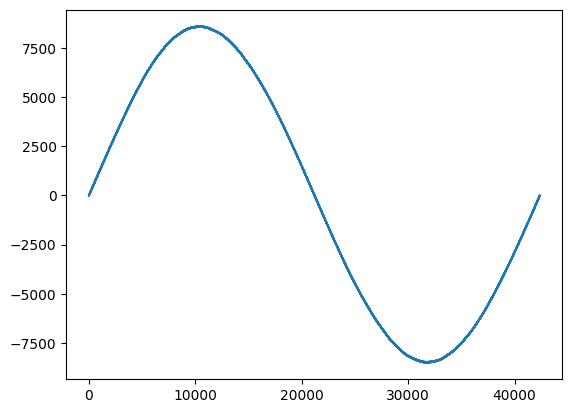

In [100]:
plt.plot(vibrometer_signal[start_idx:end_idx])
plt.show()